## Ocean with periodic boundary

In [2]:
# import a bunch of packages - don't worry about TF warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import seaborn as sns
import pickle
#from src.score import *
from collections import OrderedDict

In [3]:
# mount google drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# path to shared folder - containing relevant data
root_era5 = '/content/drive/MyDrive/2024METFUT_project_data/ERA5/'

# import the sea surface temperature, sea ice concentration, land-sea-mask
sst    = xr.open_mfdataset(root_era5+'sst_5.625deg/*.nc', combine='by_coords').load()
siconc = xr.open_mfdataset(root_era5+'siconc_5.625deg/*.nc', combine='by_coords').load()
lsm    = xr.open_dataset(root_era5+'lsm_5.625deg.nc').load()

In [5]:
# create daily climatology
sst_clim    = sst.groupby('time.dayofyear').mean()
siconc_clim = siconc.groupby('time.dayofyear').mean()

# fill nan values in datasets - otherwise no learning possible
sst = sst.fillna(sst_clim.sel(dayofyear=sst.time.dt.dayofyear))
siconc = siconc.fillna(siconc_clim.sel(dayofyear=siconc.time.dt.dayofyear))

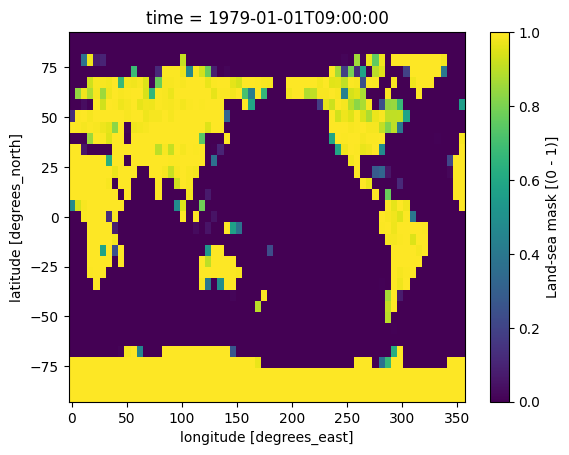

In [6]:
lsm.lsm.isel(time=0).plot()

In [7]:
# create strict land sea mask
lsm = xr.where(lsm<0.5,0,1)

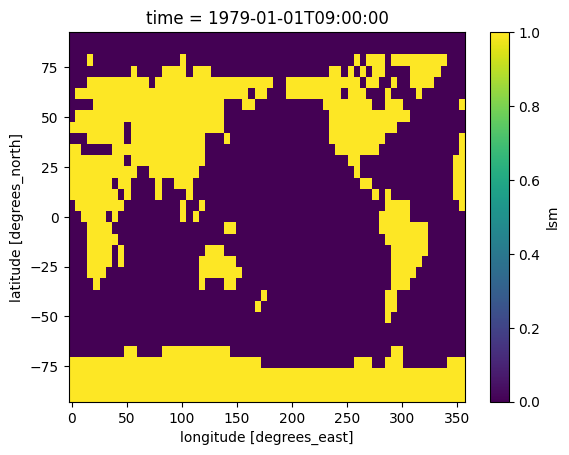

In [8]:
lsm.lsm.isel(time=0).plot()

## create the training data

In [13]:
data = xr.merge([sst, siconc])

In [23]:
# training dataset selection
train_years = slice('1979', '1982')
# validation dataset selection (this dataset helps with overfitting)
valid_years = slice('1982', '1983')
# test dataset selection
test_years = slice('1983', '1984')

In [18]:
# pick the forecast lead time
lead_time_steps = 5 # 5 day forecast considering one time step

In [68]:
def get_train_valid_test_dataset(lead_steps, datasets, variables):
  # create lists
  X_train = []
  Y_train = []
  X_valid = []
  Y_valid = []
  X_test  = []
  Y_test  = []
  mean    = np.zeros(len(datasets))
  std     = np.zeros(len(datasets))

  # iterate over index
  for i, d in enumerate(datasets):

    # Split train, valid and test dataset
    train_d = d.sel(time=train_years)
    valid_d = d.sel(time=valid_years)
    test_d  = d.sel(time=test_years)

    # Normalize the data using the mean and standard deviation of the training data
    mean[i] = d.mean()[variables[i]].values
    std[i]  = d.std()[variables[i]].values

    train_d = (train_d - mean[i]) / std[i]
    valid_d = (valid_d - mean[i]) / std[i]
    test_d  = (test_d  - mean[i]) / std[i]

    #mean = mean['sst'].values # extract numerical value from xarray Dataset
    #std = std['sst'].values # extract numerical value from xarray Dataset

    # Create inputs and outputs that are shifted by lead_steps
    X_train.append(getattr(train_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_train.append(getattr(train_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_valid.append(getattr(valid_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_valid.append(getattr(valid_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])
    X_test.append(getattr(test_d, variables[i]).isel(time=slice(None, -lead_steps)).values[..., None])
    Y_test.append(getattr(test_d, variables[i]).isel(time=slice(lead_steps, None)).values[..., None])

  # concatenate training data for multi layer input
  X_train = np.concatenate(X_train, axis = 3)
  Y_train = np.concatenate(Y_train, axis = 3)
  X_valid = np.concatenate(X_valid, axis = 3)
  Y_valid = np.concatenate(Y_valid, axis = 3)
  X_test  = np.concatenate(X_test, axis = 3)
  Y_test  = np.concatenate(Y_test, axis = 3)

  return X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std

In [69]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test, mean, std = get_train_valid_test_dataset(lead_time_steps, [sst, siconc], ['sst', 'siconc'])
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(1456, 33, 64, 2)
(1456, 33, 64, 2)
(725, 33, 64, 2)
(725, 33, 64, 2)
(726, 33, 64, 2)
(726, 33, 64, 2)
